In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from functools import partial
import scipy as sp
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm


### Sources

https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

https://michael-fuchs-python.netlify.app/2019/11/15/multinomial-logistic-regression/

Other notebooks in project

In [2]:
# Load Data
files = ["../Data/model_data/model-encoded-data-0.csv", 
         "../Data/model_data/model-encoded-data-1.csv", 
         "../Data/model_data/model-encoded-data-2.csv"]
model_dfs = [pd.read_csv(f, sep=",", 
                          encoding='Latin-1', 
                          low_memory=False ) for f in files]

# combine the list of dataframes
df = pd.concat(model_dfs, ignore_index=True)

In [3]:
# Exclude columns
cols_excl =  ['country', 'year']
df = df.drop(cols_excl, axis=1)

In [4]:
#df_salary is a dataframe after dropping data points with NaN in 'compensation'
df_salary = df.dropna(subset=['compensation'])[df.dropna(subset=['compensation'])['compensation']!=0]
print('Dataframe without NaN and 0 in compensation is {}%'.format(round(len(df_salary)/len(df)*100, 2)), 'of the original dataframe.')
print('There are {}'.format(len(df_salary)), 'data points in it compared to {}'.format(len(df)), 'entries in the original dataframe.\n')
print('Information on missing values in the dataframe df_salary:')
df_salary.isna().sum()/len(df_salary)*100

Dataframe without NaN and 0 in compensation is 100.0% of the original dataframe.
There are 252740 data points in it compared to 252740 entries in the original dataframe.

Information on missing values in the dataframe df_salary:


is_female                   0.0
is_male                     0.0
is_gender_non_confirming    0.0
is_transgender              0.0
is_gender_unknown           0.0
                           ... 
is_IT_expr_above_11         0.0
is_IT_expr_below_2          0.0
compensation                0.0
job_satisfaction            0.0
GDP                         0.0
Length: 61, dtype: float64

In [5]:
# Replace 60000-to-80000 with 60000-80000
comp_str_dict = {'60000-to-80000': '60000-80000'}
df_salary.replace({'compensation':comp_str_dict}, inplace=True)
df_salary['compensation'].value_counts()

below-20000      59338
40000-60000      39073
20000-40000      37019
60000-80000      32845
above-160000     25499
80000-100000     23519
100000-120000    16868
120000-140000    10701
140000-160000     7878
Name: compensation, dtype: int64

In [6]:
#Define data (predictors) and response
data_df = df_salary.copy()

# Some code to scale numerical data
cols_to_scale = ['job_satisfaction', 'GDP']
train_numerical = data_df[cols_to_scale].copy()
sc = StandardScaler()
sc.fit(train_numerical)
train_scaled = sc.transform(train_numerical)
train_scaled = pd.DataFrame(train_scaled, columns = train_numerical.columns)
data_df_scaled = pd.concat([data_df.drop(cols_to_scale, axis=1), train_scaled], axis=1)
 

# Keep salary as respons without changing it into numeric
salary = df_salary['compensation'].to_numpy()


data = data_df_scaled.drop('compensation', axis=1)
data = data.to_numpy()
#data = data.drop('GDP', axis=1).to_numpy()

# Define functions

In [7]:
#Define evaluation metric

def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating = None
    max_rating = None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

## Cross validation

In [8]:
#Split data
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)
cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [9]:
# Create dictionary to translate labels to ordered ints

comp_int_dict = {'below-20000': 1, '20000-40000': 2, '40000-60000': 3, '60000_to_80000': 4, '60000-80000': 4, 
                 '80000-100000': 5,'100000-120000': 6, '12000-140000': 7, '120000-140000':7,
                 '140000-160000': 8, 'above-160000': 9}

In [10]:
# Train cross validated models and compare
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    
    
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]
    
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    y_true_arr = np.array([comp_int_dict[x] for x in y_test])
    y_pred_arr = np.array([comp_int_dict[x] for x in pred])
    
    qwk = quadratic_weighted_kappa(y_pred_arr,y_true_arr)
    cv_scores[idx] = qwk

In [11]:
cv_scores

array([0.38467232, 0.37461764, 0.38139957, 0.37672015, 0.3824036 ])

##### Results are basically the same - I retrain with just one model

## Train multinomial regression model

In [12]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)


In [13]:
# Tried cross validation, but scores where almost identical. I keep just one model as working with output was easier

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
model.fit(data_train, labels_train)


# Call everything y_pred and y_true and all evaluation cell below should run fine
# Might have to change numerical labels to string and keep the correct order in a list
y_pred = model.predict(data_test)
y_true = labels_test

#List of label order
labels_order =  ['below-20000', '20000-40000', '40000-60000','60000-80000', 
                 '80000-100000','100000-120000', '120000-140000',
                 '140000-160000', 'above-160000']

### Evalutation metrics for models

In [14]:
# All interesting metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
print(f"Accuracy is: {accuracy}")

Accuracy is: 0.32921183825274986


In [15]:
macro_averaged_precision = metrics.precision_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")

Macro-Averaged Precision score: 0.25029827819730127


In [16]:
macro_averaged_recall = metrics.recall_score(y_true, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")

Macro-averaged recall score: 0.2192571896182497


In [17]:
macro_averaged_f1 = metrics.f1_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")


Macro-Averaged F1 score: 0.19640064681558642


In [18]:
y_true_arr = np.array([comp_int_dict[x] for x in y_true])
y_pred_arr = np.array([comp_int_dict[x] for x in y_pred])

kappa = quadratic_weighted_kappa(y_pred_arr,y_true_arr)

print(f"Kappa is: {kappa}")

Kappa is: 0.38192639040240706


In [19]:
# Find ROC

# Borrowed from Kaggle competition
# https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

roc_auc_dict = roc_auc_score_multiclass(y_true, y_pred)
roc_auc_dict


{'80000-100000': 0.5140105319837341,
 '20000-40000': 0.5253589270522561,
 'above-160000': 0.5461398072727034,
 '60000-80000': 0.5605466313162819,
 '40000-60000': 0.6266057783115041,
 '100000-120000': 0.5302730223272557,
 'below-20000': 0.7731719241789242,
 '140000-160000': 0.5075593900017145,
 '120000-140000': 0.5051273576790173}

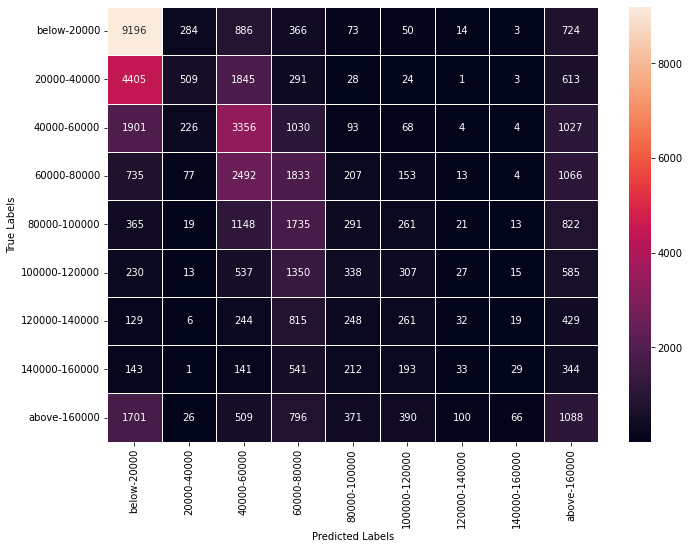

In [20]:
# Plot confusion matrix
plt.figure(figsize = (11,8))


sns.heatmap(metrics.confusion_matrix(y_true, y_pred, labels = labels_order), 
            annot = True,
            linewidths=1,
            xticklabels = labels_order, 
            yticklabels = labels_order, 
            fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()